# Recombinator Networks TensorFlow

Recombinator Networks are concatenation based methods where coarse features inform finer features early in their formation such that finer features can make use of several layers of computation in deciding how to use coarse features. This is a implementation of http://arxiv.org/abs/1511.07356 paper. You can directly download the code from https://github.com/pradyu1993/tensorflow-recombinator-networks. This post is a explaination of what is happening in the code.

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import time

FTRAIN = './data/training.csv'


## Data preprocessing 
I am using Facial keypoints dataset from kaggle for my experiments.

**Mind you** y value is scaled to stay between -1 and +1 so relu activation function will not work, because relu function output values between 0 and +1.

I took this snippet of code out of a blog post.

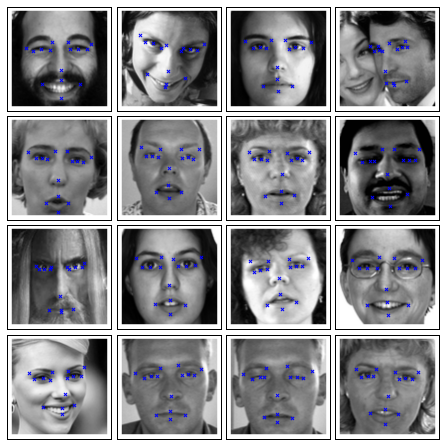

In [2]:
%matplotlib inline
def load(test=False, cols=None):
    
    fname = FTEST if test else FTRAIN
    df = pd.read_csv(os.path.expanduser(fname))  
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]
    df = df.dropna()

    X = np.vstack(df['Image'].values) / 255.
    X = X.astype(np.float32)

    if not test:
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  
        X, y = shuffle(X, y, random_state=42)  
        y = y.astype(np.float32)
    else:
        y = None

    return X, y

def load2d(test=False, cols=None):
    X, y = load(test=test)
    X = X.reshape(-1, 96, 96, 1)
    return X, y

def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

X, y = load2d();

fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(X[i], y[i], ax)

plt.show()

# Util functions

couple of util functions I will be using in the code.

1. repeat_elements function in used in upsample layer.

2. iterate_minibatches is a iterator function to return minibatches while training time.

In [3]:
def repeat_elements(x, rep, axis):
    '''Repeats the elements of a tensor along an axis, like np.repeat
    If x has shape (s1, s2, s3) and axis=1, the output
    will have shape (s1, s2 * rep, s3)
    This function is taken from keras backend
    '''
    x_shape = x.get_shape().as_list()
    splits = tf.split(axis, x_shape[axis], x)
    x_rep = [s for s in splits for i in range(rep)]
    return tf.concat(axis, x_rep)

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

# Creating and compiling Neural Net

Remember all activation functions in the network are tanh because ground truth is scaled between -1 and +1

<img src="https://github.com/SinaHonari/RCN/blob/master/Images/RCN.png">

In [4]:
class Recomb():
    def conv_filter(self, name, kw, kh, n_in, n_out):
        """
        kw, kh - filter width and height
        n_in - number of input channels
        n_out - number of output channels
        """
        kernel_init_val = tf.truncated_normal([kh, kw, n_in, n_out], dtype=tf.float32, stddev=0.1)
        kernel = tf.Variable(kernel_init_val, trainable=True, name='w')
        return kernel

    def conv_bias(self, name, n_out):
        bias_init_val = tf.constant(0.0, shape=[n_out], dtype=tf.float32)
        biases = tf.Variable(bias_init_val, trainable=True, name='b')
        return biases

    def conv_layer(self, bottom, name,kw, kh, n_out, dw=1, dh=1):

        n_in = bottom.get_shape()[-1].value
        
        with tf.variable_scope(name) as scope:
            filt = self.conv_filter(name, kw, kh, n_in, n_out)
            conv = tf.nn.conv2d(bottom, filt, (1, dh, dw, 1), padding='SAME')

            conv_biases = self.conv_bias(name, n_out)
            bias = tf.nn.bias_add(conv, conv_biases)

            relu = tf.nn.tanh(bias)
            return relu

    def mpool_op(self, bottom, name, kh=2, kw=2, dh=2, dw=2):
        return tf.nn.max_pool(bottom,
                              ksize=[1, kh, kw, 1],
                              strides=[1, dh, dw, 1],
                              padding='VALID',
                              name=name)
    
    def upsample(self,X,scale):
        output = repeat_elements(repeat_elements(X, scale[0], axis=1),scale[1], axis=2)
        return output
    

    def fc_op(self, input_op, name, n_out):
        n_in = input_op.get_shape()[-1].value

        with tf.name_scope(name) as scope:
            kernel = tf.Variable(tf.truncated_normal([n_in, n_out], dtype=tf.float32, stddev=0.1), name='w')
            biases = tf.Variable(tf.constant(0.0, shape=[n_out], dtype=tf.float32), name='b')
            activation = tf.nn.tanh(tf.matmul(input_op, kernel) + biases)
            return activation

    def build(self, input_im, dropout_keep_prob=0.75):
        net = {} 
        
        net["conv1_4"] = self.conv_layer(input_im, name="conv1_4", kh=3, kw=3, n_out=16) #b x 96 x 96 x 16
        net["conv1_4_p"] = self.mpool_op(net["conv1_4"],"conv1_4") # b x 48 x 48 x 16
        
        net["conv1_3"] = self.conv_layer(net["conv1_4_p"], name="conv1_3", kh=3, kw=3, n_out=32)
        net["conv1_3_p"] = self.mpool_op(net["conv1_3"], "conv1_3") # b x 24 x 24 x 32
        
        net["conv1_2"] = self.conv_layer(net["conv1_3_p"], name="conv1_2", kh=3, kw=3, n_out=48)
        net["conv1_2_p"] = self.mpool_op(net["conv1_2"],"conv1_2")  # b x 12 x 12 x 48
        
        net["conv1_1"] = self.conv_layer(net["conv1_2_p"], name="conv1_1", kh=3, kw=3, n_out=48) # b x 12 x 12 x 48

        net["conv2_1"] = self.upsample(net["conv1_1"], [2,2])
        concat = tf.concat(3, [net["conv2_1"], net["conv1_2"]]) # b x 24 x 24 x 96
        net["conv2_1_c"] = self.conv_layer(
                            self.conv_layer(concat,name="conv2_1_c", kh=3, kw=3, n_out=48),\
                            name="conv2_1",kh=3,kw=3,n_out=32)  # b x 24 x 24 x 32
        net["conv2_2"] = self.upsample(net["conv2_1_c"], [2,2])
        concat = tf.concat(3, [net["conv2_2"], net["conv1_3"]]) # b x 48 x 48 x 64
        net["conv2_2_c"] = self.conv_layer(
                            self.conv_layer(concat,name="conv2_2_c", kh=3, kw=3, n_out=32),\
                            name="conv2_1",kh=3,kw=3,n_out=16) # b x 48 x 48 x 16
        net["conv2_3"] = self.upsample(net["conv2_2_c"], [2,2]) 
        concat = tf.concat(3, [net["conv2_3"], net["conv1_4"]]) # b x 96 x 96 x 32
        net["conv2_3_c"] = self.conv_layer(
                            self.conv_layer(concat,name="conv2_3_c", kh=3, kw=3, n_out=16),\
                            name="conv2_1",kh=3,kw=3,n_out=5)
        
        shp = net["conv2_3_c"].get_shape()
        flattened_shape = shp[1].value * shp[2].value * shp[3].value
        flat = tf.reshape(net["conv2_3_c"], [-1, flattened_shape], name="flat")
        flat = tf.nn.dropout(flat,dropout_keep_prob, name='flat_drop')
        net["fc1"] = self.fc_op(flat, name="fc1", n_out=500)
        net["fc1_drop"] = tf.nn.dropout(net["fc1"], 0.9, name="fc1_drop")
        net["fc2"] = self.fc_op(net["fc1_drop"], name="fc2", n_out=30)
        return net

## Upsample Layer

I didnt find any upsample layer implementation in tensorflow online, so I went ahead and implemented it, below is the code for testing if the implementation is working as expected.

In [5]:
import numpy as np
np.random.seed(1337) # for reproducibility

net = Recomb()
x = tf.placeholder(tf.float32, shape=[1,2,2,1])
temp = net.upsample(x,[2,2])
sess = tf.Session()
x_t = np.random.rand(1,2,2,1)
print x_t
x_upsampled = sess.run([temp],feed_dict={x: x_t,})
print x_upsampled

[[[[ 0.26202468]
   [ 0.15868397]]

  [[ 0.27812652]
   [ 0.45931689]]]]
[array([[[[ 0.26202467],
         [ 0.26202467],
         [ 0.15868397],
         [ 0.15868397]],

        [[ 0.26202467],
         [ 0.26202467],
         [ 0.15868397],
         [ 0.15868397]],

        [[ 0.27812651],
         [ 0.27812651],
         [ 0.45931688],
         [ 0.45931688]],

        [[ 0.27812651],
         [ 0.27812651],
         [ 0.45931688],
         [ 0.45931688]]]], dtype=float32)]


# Printing Shape of layers Ouput


In [6]:
channels = 1
width, height = [96,96]
batch_size = 100
num_epochs = 400
lr=0.0001
tf.reset_default_graph()
in_images = tf.placeholder("float", [batch_size, width, height, channels])
model = Recomb()
net = model.build(in_images)
for i in net:
    print i, net[i].get_shape()

conv2_2_c (100, 48, 48, 16)
conv1_3_p (100, 24, 24, 32)
fc2 (100, 30)
fc1 (100, 500)
conv1_4_p (100, 48, 48, 16)
fc1_drop (100, 500)
conv2_1_c (100, 24, 24, 32)
conv1_1 (100, 12, 12, 48)
conv2_3 (100, 96, 96, 16)
conv1_2_p (100, 12, 12, 48)
conv2_3_c (100, 96, 96, 5)
conv1_3 (100, 48, 48, 32)
conv1_2 (100, 24, 24, 48)
conv2_2 (100, 48, 48, 32)
conv1_4 (100, 96, 96, 16)
conv2_1 (100, 24, 24, 48)


# Training

After the end of 10000 epochs RMSE was 0.03528

In [ ]:
channels = 1
width, height = [96,96]
batch_size = 100
num_epochs = 100
lr=0.01
tf.reset_default_graph()
in_images = tf.placeholder("float", [batch_size, width, height, channels])
position = tf.placeholder("float", [batch_size,y.shape[1]])
model = Recomb()
net = model.build(in_images)
last_layer = net["fc2"]
loss = tf.reduce_mean(tf.square(last_layer - position))
#loss = tf.reduce_mean(-tf.reduce_sum(position * tf.log(last_layer), reduction_indices=[1]))
optimizer = tf.train.GradientDescentOptimizer(lr)
#global_step = tf.Variable(0, name="global_step", trainable=False)
train_step = optimizer.minimize(loss)
initializer = tf.initialize_all_variables()
saver = tf.train.Saver(tf.all_variables())
with tf.Session() as sess:
    sess.run(initializer)
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        train_err = 0
        train_batches = 0
        start_time = time.time()
        for batch in iterate_minibatches(X, y, batch_size, shuffle=True):
            inputs, targets = batch
            result = sess.run(
                [train_step, loss],
                feed_dict = {
                    in_images: inputs,
                    position: targets,
                }
            )
            #print result
            train_err += result[1]
            train_batches += 1

            if np.isnan(result[1]):
                print("gradient vanished/exploded")
                break
            print '=',
        # Then we print the results for this epoch:                                                                                                                                                         
        print("\nEpoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
        if epoch%10 == 0:
            checkpoint_path = saver.save(sess, "model.ckpt")


# Visualizing Trained model

Visualizing outputs of trained model

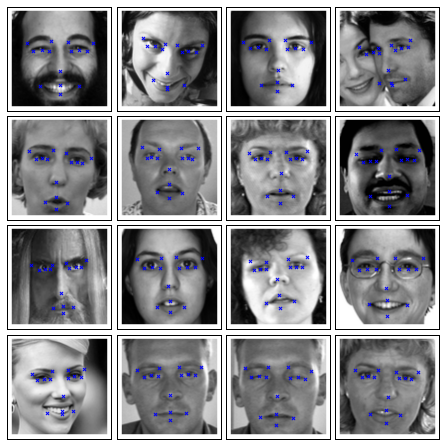

In [7]:
channels = 1
width, height = [96,96]
batch_size = 16
tf.reset_default_graph()
in_images = tf.placeholder("float", [batch_size, width, height, channels])
model = Recomb()
net = model.build(in_images)
saver = tf.train.Saver(tf.all_variables())
y_pred = []
with tf.Session() as sess:
    saver.restore(sess, "model_l30.ckpt")
    #X, y = load()
    result = sess.run(
        [net["fc2"], ],
        feed_dict = {
            in_images: X[:16,:,:,:],
        }
    )
    y_pred.append(result[0])

fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(X[i], y_pred[0][i], ax)

plt.show()
